In [2]:
import torch
import pandas as pd
from torch.autograd import Variable
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.colors as mcolors
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
from captum.attr import NoiseTunnel, Saliency, LayerGradCam
from captum.attr import visualization as viz
import pickle

In [3]:
import numpy as np

In [4]:
# load own packages
from dataset import CUBDataset
from torch.utils.data import Dataset
from inception_model import Inception3

map_location=torch.device('cpu')

ModuleNotFoundError: No module named 'inception_model'

In [5]:
# Define the paths. 


#n_attributes = 112
num_classes = 200

#mask 
mask_path = r'data\CUB_processed\filtered\mask.pkl'
mask = pd.read_pickle(mask_path)

#attribute
attribute_path = r'data\CUB_200_2011\atributes.txt'
consept_labels = pd.read_csv(attribute_path, sep=" ", header=None)[1].values
consept_labels_masked = consept_labels[mask]

In [3]:
class CUB_cordinate_Dataset(Dataset):
    """
    A dataset for the CUB dataset that returns the image, class label, attribute label and the cordinates of each concept in the image.
    """

    def __init__(self, pkl_file_paths, data_dir, uncertain_label, n_class_attr, transform,transforms_human,crop_size,mask_path=False):
        """
        Arguments:
        pkl_file_paths: list of full path to all the pkl data
        use_attr: whether to load the attributes (e.g. False for simple finetune)
        no_img: whether to load the images (e.g. False for A -> Y model)
        uncertain_label: if True, use 'uncertain_attribute_label' field (i.e. label weighted by uncertainty score, e.g. 1 & 3(probably) -> 0.75)
        image_dir: default = 'images'. Will be append to the parent dir
        n_class_attr: number of classes to predict for each attribute. If 3, then make a separate class for not visible
        transform: whether to apply any special transformation. Default = None, i.e. use standard ImageNet preprocessing
        """
        self.data = []
        self.is_train = any(["train" in path for path in pkl_file_paths])
        if not self.is_train:
            assert any([("test" in path) or ("val" in path) for path in pkl_file_paths])
        for file_path in pkl_file_paths:
            self.data.extend(pickle.load(open(file_path, 'rb')))
        self.transform = transform
        self.transforms_human = transforms_human
        self.uncertain_label = uncertain_label
        self.n_class_attr = n_class_attr
        self.crop_size = crop_size
        
        #Load concept labels names
        self.consept_labels_names = pd.read_csv(os.path.join(data_dir,"atributes.txt"), sep=" ", header=None)[1].values


        #If a filter was applied load the filter names.
        if mask_path:
            mask = pd.read_pickle(mask_path)
            self.consept_labels_names= self.consept_labels_names[mask]

        

        #Read the file with the names of bird location attributes
        self.part_names = []
        with open(os.path.join(data_dir,"parts","parts.txt")) as f:
            for line in f:
                self.part_names.append(line.strip().split(" ")[1:]) #remove the first element which is the index of the attribute
        
        self.part_locations=pd.read_csv(os.path.join(data_dir,"parts","part_locs.txt"), sep=" ", header=None)
        self.part_locations.columns = ["id","part","x","y","visible"]

    def get_cordinates(self,id,img,attr_label):
        part_names_single = ['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'eye', 'leg', 'wing', 'nape', 'tail', 'throat'] #List of all path without left and right
        coordinate_dict = {}

        for name in part_names_single:
            coordinate_dict[name] = {"coordinate":[],"visible":0}

        # Calculate crop coordinates
        orig_width, orig_height = img.size
        left = (orig_width - self.crop_size) // 2
        top = (orig_height - self.crop_size) // 2


        for index,part in self.part_locations[self.part_locations.id==id].iterrows(): #Get all the parts for the image
            name = self.part_names[int(part["part"])-1]
            
            x = part["x"] - left
            y = part["y"] - top

            if name[0] in part_names_single:


                if x >= 0 and x < self.crop_size and y >= 0 and y < self.crop_size and  part["visible"] == 1: #Check if the part is in the crop and visible
                    coordinate_dict[name[0]]["coordinate"].append((x,y))
                    coordinate_dict[name[0]]["visible"] = 1
                else:
                    coordinate_dict[name[0]]["visible"] = 0

            elif name[0] in ["left","right"]:
                if x >= 0 and x < self.crop_size and y >= 0 and y < self.crop_size and part["visible"] == 1: #Check if the part is in the crop
                    coordinate_dict[name[1]]["coordinate"].append((x,y))
                    coordinate_dict[name[1]]["visible"] = 1
                else:
                    coordinate_dict[name[1]]["visible"] = 0
            
        concept_coordinate = []

        for i in range(len(attr_label)):
            concept_name = self.consept_labels_names[i]
            concept_name = concept_name.split("_")[1] #Remove get part related to the concept

            #Apperently english has two words for the mouth of a bird and the dataset uses both. 
            if concept_name == "bill":
                concept_name = "beak"

            if concept_name in part_names_single or concept_name in ["eye","leg","wing"]: #Check if the concept is a part
                #print(f'concept_name: {concept_name} coordinate_dict {coordinate_dict[concept_name]["coordinate"]}')
                concept_coordinate.append(coordinate_dict[concept_name]["coordinate"])
            else:
                concept_coordinate.append([])
        return concept_coordinate


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Get the image path from the image dataset
        # Removed code for modifying the image path not sure if it was important or just asumed dataset to be sorted
        img_data = self.data[idx]
        img_path = img_data['img_path']
        img = Image.open(img_path).convert('RGB')
        id = img_data['id']


        class_label = img_data['class_label']

        concept_label = img_data['attribute_label']

        coordinates = self.get_cordinates(id,img,concept_label)

        img_machine = self.transform(img)
        img_human = self.transforms_human(img)


        return img_machine, class_label, concept_label, coordinates, img_human
crop_size=299
transforms_human = transforms.Compose([transforms.CenterCrop(crop_size), transforms.ToTensor()])
transforms_machine = transforms.Compose([
            #transforms.Resize((resized_resol, resized_resol)),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(), #implicitly divides by 255
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
            #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
            ])
dataset = CUB_cordinate_Dataset(pkl_file_paths=[r'data\CUB_processed\unfiltered\test.pkl'], data_dir=r'data\CUB_200_2011', uncertain_label=False, n_class_attr=2, transform=transforms_machine,transforms_human=transforms_human,crop_size=crop_size,mask_path=False)

img, class_label, concept_label, coordinates, img_human = dataset[0]


['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'left eye', 'left leg', 'left wing', 'nape', 'right eye', 'right leg', 'right wing', 'tail', 'throat']


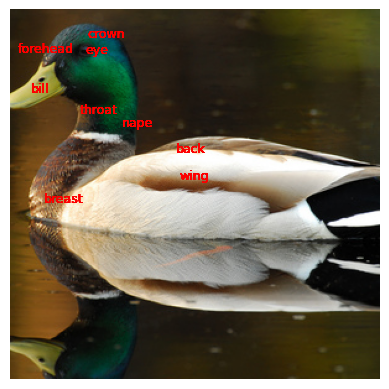

In [73]:

#idx = 788

#idx = 2450 #2456 #2460 #2461 #2463 #2469 #2471
idx = 2471

img, class_label, concept_label, coordinates, img_human = dataset[idx]

plt.imshow(img_human.permute(1, 2, 0))


atribute_locations_names = []

#Read txt file
with open(r"data\CUB_200_2011\parts\parts.txt") as f:
    for line in f:
        atribute_locations_names.append(" ".join(line.strip().split(" ")[1:]))
print(atribute_locations_names)
for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:
        #print(f'coordinates {coordinates[i]} atribute_locations_names {consept_labels_masked[i]}')
        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=consept_labels[i].split("_")[1]
            if name == "forehead":
                ofset = -30

            elif name == "eye":
                ofset = 0
            else:
                ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

In [7]:

for i,d in enumerate(dataset.data):
    if d['class_label'] == 86:
        print(i)

2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474


['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'left eye', 'left leg', 'left wing', 'nape', 'right eye', 'right leg', 'right wing', 'tail', 'throat']


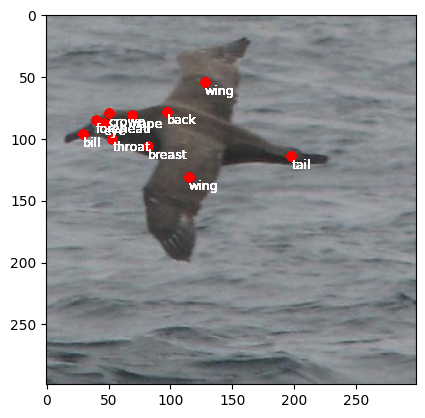

In [6]:
plt.imshow(img_human.permute(1, 2, 0))
atribute_locations_names = []

#Read txt file
with open(r"data\CUB_200_2011\parts\parts.txt") as f:
    for line in f:
        atribute_locations_names.append(" ".join(line.strip().split(" ")[1:]))
print(atribute_locations_names)
for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:
        #print(f'coordinates {coordinates[i]} atribute_locations_names {consept_labels_masked[i]}')
        for x,y in coordinates[i]:
            plt.plot(x,y,'ro')
            plt.text(x,y+10,consept_labels[i].split("_")[1],fontsize=9,color='white')
            

plt.show()

In [7]:
#Test model
pkl_paths = [r'data\CUB_processed\filtered\val.pkl']
image_dir = r'data\CUB_200_2011\CUB_200_2011\images\val'



In [8]:
atribute_locations=pd.read_csv(r"data\CUB_200_2011\parts\part_locs.txt", sep=" ", header=None)
atribute_locations.columns = ["id","part","x","y","visible"]
atribute_locations

,id,part,x,y,visible
0,1,1,0.0,0.0,0
1,1,2,312.0,182.0,1
2,1,3,0.0,0.0,0
3,1,4,0.0,0.0,0
4,1,5,186.0,45.0,1
...,...,...,...,...,...
176815,11788,11,136.0,133.0,1
176816,11788,12,102.0,316.0,1
176817,11788,13,94.0,224.0,1
176818,11788,14,36.0,329.0,1


In [9]:
model_path = r'models\Unfiltered\Random_start\best_model_1.pth'
model=torch.load(model_path, map_location=map_location)

C:\Users\Andre\AppData\Local\Temp\ipykernel_18452\2704975667.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load(model_path, map_location=map_location)


In [44]:

def get_saliency_maps(img, model, target_classes, method_type='vanilla'):
    # Load and preprocess the image
    img.requires_grad_(True)

    # Initialize the appropriate method
    if method_type == 'vanilla':
        saliency = Saliency(model)
    elif method_type == 'noise_tunnel':
        saliency = NoiseTunnel(Saliency(model))
    elif method_type == 'gradcam':
        layer = model.model.Conv2d_2b_3x3
        saliency = LayerGradCam(model, layer)
    else:
        raise ValueError("Invalid method_type. Choose from 'vanilla', 'noise_tunnel', or 'gradcam'.")

    saliency_maps = []

    # Loop over all the target classes
    for target_class in target_classes:
        if method_type == 'vanilla':
            # Compute vanilla saliency
            attribution = saliency.attribute(img, target=target_class)
        elif method_type == 'noise_tunnel':
            # Compute saliency with noise tunneling
            attribution = saliency.attribute(img, target=target_class, nt_type='smoothgrad', nt_samples=50, stdevs=0.2)
        
        """
        TODO fingure out how to get gradcam to work with inception
        elif method_type == 'gradcam':
            # Compute GradCAM
            attribution = saliency.attribute(img, target=target_class)
            attribution = torch.mean(attribution, dim=1, keepdim=True)  # Average across channels

        saliency_map = attribution.squeeze().cpu().detach().numpy()  # Convert attribution to numpy array
        print(saliency_map.shape)
        saliency_map = np.abs(saliency_map).sum(axis=0)  # Sum the absolute value of the attributions across color channels
        saliency_map = saliency_map / saliency_map.sum()  # Normalize the saliency map
        saliency_maps.append(saliency_map)
        """

    return saliency_maps

def saliency_score_part(saliency_map, coordinates):
    """
    Calculate a score of a single part based on the sailency activation times the manhatten distance to the coordinates. 
    args: sailency: np.array: The sailency map
    cords: list of tuples: The coordinates to calculate the distance to
    return: float: The score
    """
    if len(coordinates) == 0:
        # make warning that no coordinates are given
        print("No coordinates given")
        return 0

 

    #Return the score
    return (saliency_map * M).sum()/M.mean()

def saliency_score_image(sailency, coordinates):
    """
    Calculate a average score of all the parts in the image
    args: sailency: list of np.array: The sailency maps
    cords: list of list of tuples: The coordinates to calculate the distance to
    return: float: The score
    """



    score = 0
    for s,c in zip(sailency,coordinates):
        score += saliency_score_part(s,c)
    
    return score/len(coordinates)

def get_visible_consepts(coordinates):
    """
    Get the indexes of the visible consepts
    args: coordinates: list of list of tuples: The coordinates to calculate the distance to
    return: list of int: The indexes of the visible consepts
    """
    # Find parts that are in the image, a part is in the image if it has at least one coordinate
    visible_idx = []
    visible_consepts = []
    for i,c in enumerate(coordinates):
        if len(c) > 0: #Check if the part has any coordinates
            if c[0] != (0,0): #Check if the coordinates are not default for not visible
                visible_idx.append(i)
                visible_consepts.append(c)
    return visible_idx,visible_consepts




In [46]:
visible_consepts = []

for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:
        visible_consepts.append(i)

def plot_saliency_map(axs, saliency, coordinates):
    if saliency.ndim == 2:
        axs.imshow(saliency, cmap='jet', interpolation='nearest')
    elif saliency.ndim == 3 and saliency.shape[2] in [3, 4]:
        axs.imshow(saliency, interpolation='nearest')
    else:
        print(saliency.shape)
        raise ValueError(f"Invalid shape {saliency.shape} for saliency map")
    axs.axis('off')
    for x,y in coordinates:
        axs.plot(x,y,'ro')

#visible_consepts = visible_consepts[:10]

N = len(visible_consepts)

#Plot all the consepts
n_rows=int((N)/10)+1

fig, axs = plt.subplots(n_rows,10, figsize=(100, 10*n_rows))

#original_image = (original_image.detach().numpy().transpose(1,2,0)+0.25)*2
#Plot the original image
axs[0,0].imshow(img_human.numpy().transpose(1,2,0))
axs[0,0].axis('off')
axs[0,0].set_title('Original Image',fontsize=40)

saliencys = get_saliency_maps(img.unsqueeze(0), model, visible_consepts,method_type="noise_tunnel")

for n,id in enumerate(visible_consepts):
    #Get the saliency map

    saliency = saliencys[n]
    plot_saliency_map(axs[int((n+1)/10),(n+1)%10], saliency, coordinates[id])
    value = saliency_score_part(saliency, coordinates[id])
    axs[int((n+1)/10),(n+1)%10].set_title(f'{consept_labels[id]} \n value {np.round(value,6)}',fontsize=30)

(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 299, 299)
(3, 29

KeyboardInterrupt: 

In [12]:
len(dataset)

4796

In [13]:


#Load the model

image_values = []

for data in iter(dataset):
    img, class_label, concept_label, coordinates, img_human = data
    print(f'Image {len(concept_label)}')
    visible_idx,visible_consepts = get_visible_consepts(coordinates)
    print(f'Visible consepts {len(visible_consepts)}')
    saliencys = get_saliency_maps(img.unsqueeze(0), model, visible_idx)
    value=saliency_score_image(saliencys,visible_consepts)
    image_values.append(value)
    print(f'Image {len(image_values)} value {value}')

print(f'Mean value {np.mean(image_values)}')
plt.hist(image_values,bins=100)
plt.show()

Image 312
Visible consepts 188


KeyboardInterrupt: 

In [32]:

def saliency_score_part(saliency_map, coordinates):
    """
    Calculate a score of a single part based on the sailency activation times the manhatten distance to the coordinates. 
    args: sailency: np.array: The sailency map
    cords: list of tuples: The coordinates to calculate the distance to
    return: float: The score
    """

    height, width = saliency_map.shape  # Get the dimensions of the saliency map

    # Create coordinate grids for the entire map
    y_coords, x_coords = np.ogrid[:height, :width]

    distances = []
    
    for target_y, target_x in coordinates:
        # Calculate Manhattan distances from each point to the target coordinate
        distances.append(np.abs(y_coords - target_y) + np.abs(x_coords - target_x))
    
    if len(distances) ==1: #If only one coordinate return the sum of the score
        M = distances[0]

    else:
        # If multiple coordinates return the minimum distance for each coordinate
        M = np.stack(distances).min(axis=0)

    #Return the score
    return (saliency_map * M).sum()/M.mean()

for n,id in enumerate(visible_consepts):
    T = np.random.rand(299,299)
    T/=T.sum()

    print(saliency_score_part(saliency, coordinates[id]))

TypeError: list indices must be integers or slices, not list